# Import the necessary Libraries

In [1]:
import os
import shutil
import tarfile
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

from transformers import BertTokenizer, TFBertForSequenceClassification


import pandas as pd
from bs4 import BeautifulSoup
import re

import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# Load the dataset

In [2]:
# Get the current working directory
current_folder = os.getcwd()

dataset = tf.keras.utils.get_file(
    fname ="aclImdb.tar.gz", 
    origin ="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz",
    cache_dir=  current_folder,
    extract = True)

84125825/84125825 [==============================] - 8s 0us/step


In [3]:
dataset_path = os.path.dirname(dataset)
# Check the dataset
os.listdir(dataset_path)

['aclImdb', 'aclImdb.tar.gz']

In [4]:
# Dataset directory
dataset_dir = os.path.join(dataset_path, 'aclImdb')

# Check the Dataset directory
os.listdir(dataset_dir)

['README', 'train', 'imdb.vocab', 'imdbEr.txt', 'test']

## Training Dataset

In [5]:
train_dir = os.path.join(dataset_dir,'train')
os.listdir(train_dir)

['urls_unsup.txt',
 'pos',
 'unsupBow.feat',
 'urls_neg.txt',
 'labeledBow.feat',
 'neg',
 'unsup',
 'urls_pos.txt']

In [6]:
for file in os.listdir(train_dir):
    file_path = os.path.join(train_dir, file)
    # Check if it's a file (not a directory)
    if os.path.isfile(file_path): 
        with open(file_path, 'r', encoding='utf-8') as f:
            first_value = f.readline().strip()
            print(f"{file}: {first_value}")
    else:
        print(f"{file}: {file_path}")

urls_unsup.txt: http://www.imdb.com/title/tt0018515/usercomments
pos: /kaggle/working/datasets/aclImdb/train/pos
unsupBow.feat: 0 0:8 1:6 3:5 4:2 5:1 7:1 8:5 9:2 10:1 11:2 13:3 16:1 17:1 18:1 19:1 22:3 24:1 26:3 28:1 30:1 31:1 35:2 36:1 39:2 40:1 41:2 46:2 47:1 48:1 52:1 63:1 67:1 68:1 74:1 81:1 83:1 87:1 104:1 105:1 112:1 117:1 131:1 151:1 155:1 170:1 198:1 225:1 226:1 288:2 291:1 320:1 331:1 342:1 364:1 374:1 384:2 385:1 407:1 437:1 441:1 465:1 468:1 470:1 519:1 595:1 615:1 650:1 692:1 851:1 937:1 940:1 1100:1 1264:1 1297:1 1317:1 1514:1 1728:1 1793:1 1948:1 2088:1 2257:1 2358:1 2584:2 2645:1 2735:1 3050:1 4297:1 5385:1 5858:1 7382:1 7767:1 7773:1 9306:1 10413:1 11881:1 15907:1 18613:1 18877:1 25479:1
urls_neg.txt: http://www.imdb.com/title/tt0064354/usercomments
labeledBow.feat: 9 0:9 1:1 2:4 3:4 4:6 5:4 6:2 7:2 8:4 10:4 12:2 26:1 27:1 28:1 29:2 32:1 41:1 45:1 47:1 50:1 54:2 57:1 59:1 63:2 64:1 66:1 68:2 70:1 72:1 78:1 100:1 106:1 116:1 122:1 125:1 136:1 140:1 142:1 150:1 167:1 183:

In [7]:
def load_dataset(directory):
    data = {"sentence": [], "sentiment": []}
    for file_name in os.listdir(directory):
        print(file_name)
        if file_name == 'pos':
            positive_dir = os.path.join(directory, file_name)
            for text_file in os.listdir(positive_dir):
                text = os.path.join(positive_dir, text_file)
                with open(text, "r", encoding="utf-8") as f:
                    data["sentence"].append(f.read())
                    data["sentiment"].append(1)
        elif file_name == 'neg':
            negative_dir = os.path.join(directory, file_name)
            for text_file in os.listdir(negative_dir):
                text = os.path.join(negative_dir, text_file)
                with open(text, "r", encoding="utf-8") as f:
                    data["sentence"].append(f.read())
                    data["sentiment"].append(0)
            
    return pd.DataFrame.from_dict(data)

# Load the dataset from the train_dir
train_df = load_dataset(train_dir)
print(train_df.head())

urls_unsup.txt
pos
unsupBow.feat
urls_neg.txt
labeledBow.feat
neg
unsup
urls_pos.txt
                                            sentence  sentiment
0  A fey story of a Martian attempt to colonize E...          1
1  All of you who despaired looking at the emptin...          1
2  If Mulder was looking for his real father here...          1
3  Sigh I sincerely wonder why all the acclaimed...          1
4  This movie displays the kind of ensemble work ...          1


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentence   25000 non-null  object
 1   sentiment  25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


In [9]:
test_dir = os.path.join(dataset_dir,'test')
os.listdir(test_dir)

['pos', 'urls_neg.txt', 'labeledBow.feat', 'neg', 'urls_pos.txt']

In [10]:
# Load the dataset from the train_dir
test_df = load_dataset(test_dir)
test_df.head()

pos
urls_neg.txt
labeledBow.feat
neg
urls_pos.txt


,sentence,sentiment
0,This movie is not about the soda nor is it qui...,1
1,This is one of the very best films i've seen i...,1
2,"This is a well directed Columbo episode, with ...",1
3,Great movie. Post-apocalyptic films kick ass. ...,1
4,Six out of seven people who took the time to c...,1


In [11]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentence   25000 non-null  object
 1   sentiment  25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


# Text Preprocessing

In [12]:
counts = train_df['sentiment'].value_counts()

In [13]:
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objects as go

In [14]:
sentiment_counts = train_df['sentiment'].value_counts()
fig =px.bar(x= {0:'Negative',1:'Positive'},
            y= sentiment_counts.values,
            color=sentiment_counts.index,
            color_discrete_sequence =  px.colors.qualitative.Dark24,
            title='<b>Sentiments Counts')

fig.update_layout(title='Sentiments Counts',
                  xaxis_title='Sentiment',
                  yaxis_title='Counts',
                  template='plotly_dark')

# Show the bar chart
fig.show()
pyo.plot(fig, filename = 'Sentiments Counts.html', auto_open = True)

'Sentiments Counts.html'

In [15]:
def text_cleaning(text):
    soup = BeautifulSoup(text, "html.parser")
    text = re.sub(r'\[[^]]*\]', '', soup.get_text())
    pattern = r"[^a-zA-Z0-9\s,']"
    text = re.sub(pattern, '', text)
    return text

In [16]:
train_df['Cleaned_sentence'] = train_df['sentence'].apply(text_cleaning).tolist()
train_df.head()

/tmp/ipykernel_23/3524044076.py:2: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.



,sentence,sentiment,Cleaned_sentence
0,A fey story of a Martian attempt to colonize E...,1,A fey story of a Martian attempt to colonize E...
1,All of you who despaired looking at the emptin...,1,All of you who despaired looking at the emptin...
2,If Mulder was looking for his real father here...,1,If Mulder was looking for his real father here...
3,Sigh I sincerely wonder why all the acclaimed...,1,Sigh I sincerely wonder why all the acclaimed...
4,This movie displays the kind of ensemble work ...,1,This movie displays the kind of ensemble work ...


In [17]:
# Function to generate word cloud
def generate_wordcloud(text,Title):
    all_text = " ".join(text)
    wordcloud = WordCloud(width=800, 
                          height=400,
                          stopwords=set(STOPWORDS), 
                          background_color='black').generate(all_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(Title)
    plt.show()

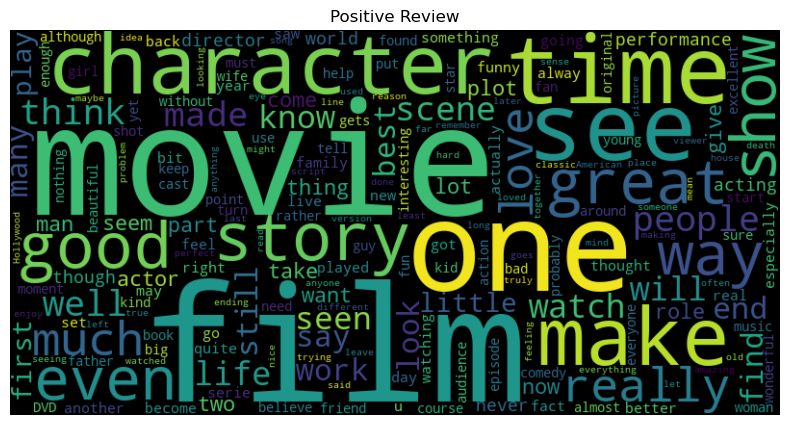

In [18]:
positive = train_df[train_df['sentiment']==1]['Cleaned_sentence'].tolist()
generate_wordcloud(positive,'Positive Review')

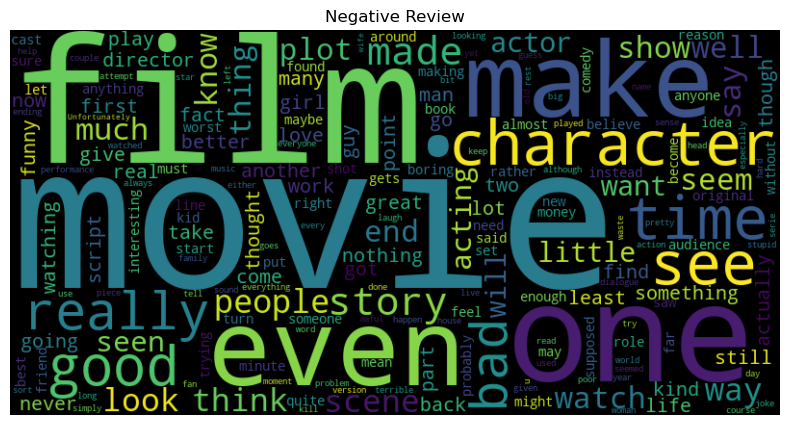

In [19]:
negative = train_df[train_df['sentiment']==0]['Cleaned_sentence'].tolist()
generate_wordcloud(negative,'Negative Review')

In [20]:
test_df['Cleaned_sentence'] = test_df['sentence'].apply(text_cleaning)
test_df.head()

/tmp/ipykernel_23/3524044076.py:2: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.



,sentence,sentiment,Cleaned_sentence
0,This movie is not about the soda nor is it qui...,1,This movie is not about the soda nor is it qui...
1,This is one of the very best films i've seen i...,1,This is one of the very best films i've seen i...
2,"This is a well directed Columbo episode, with ...",1,"This is a well directed Columbo episode, with ..."
3,Great movie. Post-apocalyptic films kick ass. ...,1,Great movie Postapocalyptic films kick ass Thi...
4,Six out of seven people who took the time to c...,1,Six out of seven people who took the time to c...


In [21]:
#Reviews = "[CLS] " +train_df['Cleaned_sentence'] + "[SEP]"
Reviews = train_df['Cleaned_sentence']
Target = train_df['sentiment']

In [22]:
#test_reviews =  "[CLS] " +test_df['Cleaned_sentence'] + "[SEP]"
test_reviews = test_df['Cleaned_sentence']
test_targets = test_df['sentiment']

# Split TEST data into test and validation

In [23]:
x_val, x_test, y_val, y_test = train_test_split(test_reviews,
                                                    test_targets,
                                                    test_size=0.5, 
                                                    stratify = test_targets)

# Tokenization & Encoding

In [24]:
#Tokenize and encode the data using the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [25]:
max_len= 128
# Tokenize and encode the sentences
X_train_encoded = tokenizer.batch_encode_plus(Reviews.tolist(),
                                              padding=True, 
                                              truncation=True,
                                              max_length = max_len,
                                              return_tensors='tf')

X_val_encoded = tokenizer.batch_encode_plus(x_val.tolist(), 
                                              padding=True, 
                                              truncation=True,
                                              max_length = max_len,
                                              return_tensors='tf')

X_test_encoded = tokenizer.batch_encode_plus(x_test.tolist(), 
                                              padding=True, 
                                              truncation=True,
                                              max_length = max_len,
                                              return_tensors='tf')

In [26]:
k = 0
print('Training Comments -->>',Reviews[k])
print('\nInput Ids -->>\n',X_train_encoded['input_ids'][k])
print('\nDecoded Ids -->>\n',tokenizer.decode(X_train_encoded['input_ids'][k]))
print('\nAttention Mask -->>\n',X_train_encoded['attention_mask'][k])
print('\nLabels -->>',Target[k])

Training Comments -->> A fey story of a Martian attempt to colonize Earth Things must be pretty bad back on Mars Two state troopers investigate the scene of a reported UFO crash Whatever landed is buried under the ice at Tracy's Pond but there are footsteps in the snow leading to a nearby dinerThe diner has had no customers since eleven o'clock that morning Now there are a handful of bus passengers sitting around waiting for permission to cross a structurally weak bridge The bus driver insists that six passengers were aboard the bus, although he didn't notice who they were The problem is that there are now SEVEN people waiting for the journey to be resumed One of them is an alien, but which one All of them are suspect There's the crazy old man Jack Elam, of course, who seems to exercise a sub rosa wit There's a blustering businessman who must get to Boston John Hoyt A young couple on their honeymoon Execrable performance by the husband, Ron Kipling Except for the couples, nobody has no

In [27]:
# Intialize the model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)


# Compile the model with an appropriate optimizer, loss function, and metrics
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

model.summary()

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [28]:
# Step 5: Train the model
history = model.fit(
    [X_train_encoded['input_ids'], X_train_encoded['token_type_ids'], X_train_encoded['attention_mask']],
    Target,
    validation_data=([X_val_encoded['input_ids'], X_val_encoded['token_type_ids'], X_val_encoded['attention_mask']],y_val),
    batch_size=32,
    epochs=3
)

Epoch 1/3
782/782 [==============================] - 513s 587ms/step - loss: 0.3445 - accuracy: 0.8446 - val_loss: 0.2710 - val_accuracy: 0.8880
Epoch 2/3
782/782 [==============================] - 432s 552ms/step - loss: 0.2062 - accuracy: 0.9186 - val_loss: 0.2686 - val_accuracy: 0.8886
Epoch 3/3
782/782 [==============================] - 431s 551ms/step - loss: 0.1105 - accuracy: 0.9615 - val_loss: 0.3235 - val_accuracy: 0.8908


# Model Evaluations

In [29]:
#Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(
    [X_test_encoded['input_ids'], X_test_encoded['token_type_ids'], X_test_encoded['attention_mask']],
    y_test
)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')

391/391 [==============================] - 67s 171ms/step - loss: 0.3417 - accuracy: 0.8873
Test loss: 0.3417432904243469, Test accuracy: 0.8872799873352051


# Save and load the model and tokenizer

In [30]:
path = '/kaggle/working/'
# Save tokenizer
tokenizer.save_pretrained(path +'/Tokenizer')

# Save model
model.save_pretrained(path +'/Model')

In [31]:
# Load tokenizer
bert_tokenizer = BertTokenizer.from_pretrained(path +'/Tokenizer')

# Load model
bert_model = TFBertForSequenceClassification.from_pretrained(path +'/Model')

Some layers from the model checkpoint at /kaggle/working//Model were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /kaggle/working//Model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


## Predict

In [32]:
pred = bert_model.predict([X_test_encoded['input_ids'], X_test_encoded['token_type_ids'], X_test_encoded['attention_mask']])

# pred is of type TFSequenceClassifierOutput
logits = pred.logits

# Use argmax along the appropriate axis to get the predicted labels
pred_labels = tf.argmax(logits, axis=1)

# Convert the predicted labels to a NumPy array
pred_labels = pred_labels.numpy()

label = {
    1:'positive',
    0:'Negative'
}

# Map the predicted labels to their corresponding strings using the label dictionary
pred_labels = [label[i] for i in pred_labels]
Actual = [label[i] for i in y_test]

print('Predicted Label :',pred_labels[:10])
print('Actual Label    :',Actual[:10])

391/391 [==============================] - 68s 167ms/step
Predicted Label : ['positive', 'positive', 'positive', 'positive', 'positive', 'Negative', 'Negative', 'Negative', 'positive', 'positive']
Actual Label    : ['positive', 'positive', 'positive', 'Negative', 'positive', 'Negative', 'Negative', 'Negative', 'positive', 'positive']


## Classifiaction Report

In [33]:
print("Classification Report: \n", classification_report(Actual, pred_labels))

Classification Report: 
               precision    recall  f1-score   support

    Negative       0.91      0.86      0.88      6250
    positive       0.87      0.91      0.89      6250

    accuracy                           0.89     12500
   macro avg       0.89      0.89      0.89     12500
weighted avg       0.89      0.89      0.89     12500



# Prediction with user inputs

In [34]:
def Get_sentiment(Review, Tokenizer=bert_tokenizer, Model=bert_model):
    # Convert Review to a list if it's not already a list
    if not isinstance(Review, list):
        Review = [Review]

    Input_ids, Token_type_ids, Attention_mask = Tokenizer.batch_encode_plus(Review,
                                                                             padding=True,
                                                                             truncation=True,
                                                                             max_length=128,
                                                                             return_tensors='tf').values()
    prediction = Model.predict([Input_ids, Token_type_ids, Attention_mask])

    # Use argmax along the appropriate axis to get the predicted labels
    pred_labels = tf.argmax(prediction.logits, axis=1)

    # Convert the TensorFlow tensor to a NumPy array and then to a list to get the predicted sentiment labels
    pred_labels = [label[i] for i in pred_labels.numpy().tolist()]
    return pred_labels

Review = '''Bahubali is a blockbuster Indian movie that was released in 2015. 
It is the first part of a two-part epic saga that tells the story of a legendary hero who fights for his kingdom and his love. 
The movie has received rave reviews from critics and audiences alike for its stunning visuals, 
spectacular action scenes, and captivating storyline.'''
sentiment = Get_sentiment(Review)
print(sentiment)

1/1 [==============================] - 3s 3s/step
['positive']
